In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Introduction](#chapter0)
* [Make RBC Model](#chapter3)
    * [Model Equations](#section_3_1)
    * [Find Steady State, Solve the Model](#section_3_2)
    * [Check Blanchard Kahn Conditions](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [A Simple Model](#section_4_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_1)
        * [Forecasting](#subsection_4_2)
    * [A Noisy Model](#section_4_2)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_3)
        * [Forecasting](#subsection_4_4)
    * [Adding Variables](#section_4_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_5)
        * [Forecasting](#subsection_4_6)
    * [Final Model](#section_4_4)
        * [MLE Kalman Filter Prediction Plots](#subsection_4_7)
        * [Forecasting](#subsection_4_8)
    * [Impulse response](#section_4_5)
        * [New Steady State](#subsection_4_9)

## Introduction <a class="anchor" id="chapter0"></a>

In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
from gEconpy.shared.utilities import eq_to_ss
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

In [4]:
# load data
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# drop csv index
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

# time format index
train['TIME'] = time_format(train.TIME)
test['TIME'] = time_format(test.TIME)

# set index - get's lost with csv
train.set_index('TIME', inplace=True)
test.set_index('TIME', inplace=True)

# asign correct time freq
train = train.asfreq('QS')
test = test.asfreq('QS')

glob_cols = list(train.columns)
test_size = len(test)

# Capital Adjustment cost Model <a class="anchor" id="chapter3"></a>

In [5]:
# rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_capadj.gnc'))

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_3_1"></a>

In [6]:
for equation in rbc.system_equations:
    display(equation)

-Q_t + lambda_t/q_t

-C_t - I_t + K_t-1*r_t + L_t*w_t

-1*phi*(-delta + I_t/K_t-1)**2*K_t-1/2 + I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

-lambda_t - q_t*(phi*(-delta + I_t/K_t-1) - 1)

beta*(lambda_t+1*r_t+1 - q_t+1*(delta - phi*I_t+1*(-delta + I_t+1/K_t)/K_t + phi*(-delta + I_t+1/K_t)**2/2 - 1)) - q_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

In [7]:
eq_ss = eq_to_ss(rbc.system_equations[2])

In [8]:
eq_ss

-phi*K_ss*(-delta + I_ss/K_ss)**2/2 + I_ss + K_ss*(1 - delta) - K_ss

In [9]:
I_ss = TimeAwareSymbol('I', 'ss')
I_ss

I_ss

There are two solutions for I_ss!

In [10]:
I_ss_solved = sp.solve(eq_ss, I_ss)
for x in I_ss_solved:
    display(x)

delta*K_ss

K_ss*(delta*phi + 2)/phi

In [11]:
eq2 = eq_to_ss(rbc.system_equations[5])
eq2

-lambda_ss - q_ss*(phi*(-delta + I_ss/K_ss) - 1)

Depending on which one we choose, we either get $q_{ss} = \lambda_{ss}$, or $q_{ss} = -\lambda_{ss}$

In [12]:
q_ss = TimeAwareSymbol('q', 'ss')
q_ss_solved_1 = sp.solve(eq2.subs({I_ss:I_ss_solved[0]}), q_ss)[0]
q_ss_solved_1

lambda_ss

In [13]:
q_ss_solved_2 = sp.solve(eq2.subs({I_ss:I_ss_solved[1]}), q_ss)[0]
q_ss_solved_2

-lambda_ss

And depending on THAT choice, we end up with one of two expressions for the interest rate

In [14]:
eq3 = rbc.system_equations[6]
eq3

beta*(lambda_t+1*r_t+1 - q_t+1*(delta - phi*I_t+1*(-delta + I_t+1/K_t)/K_t + phi*(-delta + I_t+1/K_t)**2/2 - 1)) - q_t

Choosing $I_{ss} = \delta K_{ss}$ leads to the usual expression for $r_{ss}$

In [15]:
r_ss = TimeAwareSymbol('r', 'ss')
sp.solve(eq_to_ss(eq3).subs({I_ss:I_ss_solved[0], q_ss:q_ss_solved_1}), r_ss)[0]

delta - 1 + 1/beta

While choosing $I_{ss} = (\frac{2}{\phi} + \delta)K_{ss}$ leads to a different formula.

**Question**: What does $\phi$ represent? Is this $r_{ss}$ higher or lower than the "usual" one?

In [16]:
sp.solve(eq_to_ss(eq3).subs({I_ss:I_ss_solved[1], q_ss:q_ss_solved_2}), r_ss)[0]

delta + 1 + 2/phi - 1/beta

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [17]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.831805550351403e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [18]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Q_ss               1.000
Y_ss               3.073
lambda_ss          0.276
q_ss               0.276
r_ss               0.030
w_ss               2.436


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [19]:
rbc.check_bk_condition()

Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,1.020938e-36,-1.020938e-36,-0.0
1,1.516373e-18,-1.516373e-18,-0.0
2,2.841528e-18,-2.841528e-18,-0.0
3,9.500000e-01,9.500000e-01,0.0
4,9.718046e-01,9.718046e-01,0.0
5,1.039407e+00,1.039407e+00,0.0
6,1.173431e+07,1.173431e+07,0.0
7,2.627046e+07,2.627046e+07,0.0
8,3.167662e+07,3.167662e+07,0.0


In [20]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [21]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,0.034739,0.025376,0.030090,0.073761,NaN,0.006896
1996-04-01,-0.023203,0.006568,0.023159,-0.032295,NaN,NaN
1996-07-01,-0.047401,-0.006060,0.019601,-0.077407,NaN,NaN
1996-10-01,-0.040238,-0.003936,0.010456,-0.046165,NaN,NaN
1997-01-01,-0.037205,-0.012070,0.009416,-0.052189,NaN,-0.005354


## Final model <a class="anchor" id="section_4_4"></a>

In [22]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [23]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':0.1,
                    'sigma_L':0.3,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=0.001, high=5.0),
                    'sigma_L':IntervalTransformer(low=0.001, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [24]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=10)

In [25]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                                  DSGEModel   Log Likelihood                 124.542
Date:                            Fri, 09 Dec 2022   AIC                           -225.083
Time:                                    23:54:32   BIC                           -196.499
Sample:                                01-01-1996   HQIC                          -213.623
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.6384      2.623      0.243      0.808      -4.502       5.779
sigma_C              0.5046     10.304      0.049      0.961     -19.690      20.700
sigma_L              0.6837     31.288      0.022      0.983     -60.639      62.007
alpha                0.3839     11.680      0.033      0.974     -22.508      23.276
beta                 0.9973      0.855      1.166      0.244      -0.679       2.674
delta                0.0370      0.510      0.073      0.942      -0.962       1.036
sigma2.epsilon_A     0.0276      0.549      0.050      0.960      -1.048       1.104
sigma2.L             0.2494      0.140      1.781      0.075      -0.025       0.524
sigma2.w             0.0973      0.063      1.533      0.125      -0.027       0.222
sigma2.r             0.0523      0.590      0.089      0.929      -1.104       1.208
sigma2.C             0.0259      0.132      0.195      0.845      -0.233       0.285
sigma2.I             0.3342      5.319      0.063      0.950     -10.091      10.760
===============================================================================================================================
Ljung-Box (L1) (Q):     25.70, 0.00, 64.82, 61.62, 54.48, 61.38   Jarque-Bera (JB):   246.75, 585.84, 52.61, 93.99, 1.61, 46.29
Prob(Q):                     0.00, 1.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                  0.00, 0.00, 0.00, 0.00, 0.45, 0.00
Heteroskedasticity (H):       0.69, 0.62, inf, 2.00, 1.71, 2.04   Skew:                    -1.87, 1.77, 0.91, 1.68, -0.33, 1.29
Prob(H) (two-sided):         0.35, 0.22, 0.00, 0.08, 0.17, 0.07   Kurtosis:                10.75, 15.78, 6.53, 7.11, 3.21, 5.69
===============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

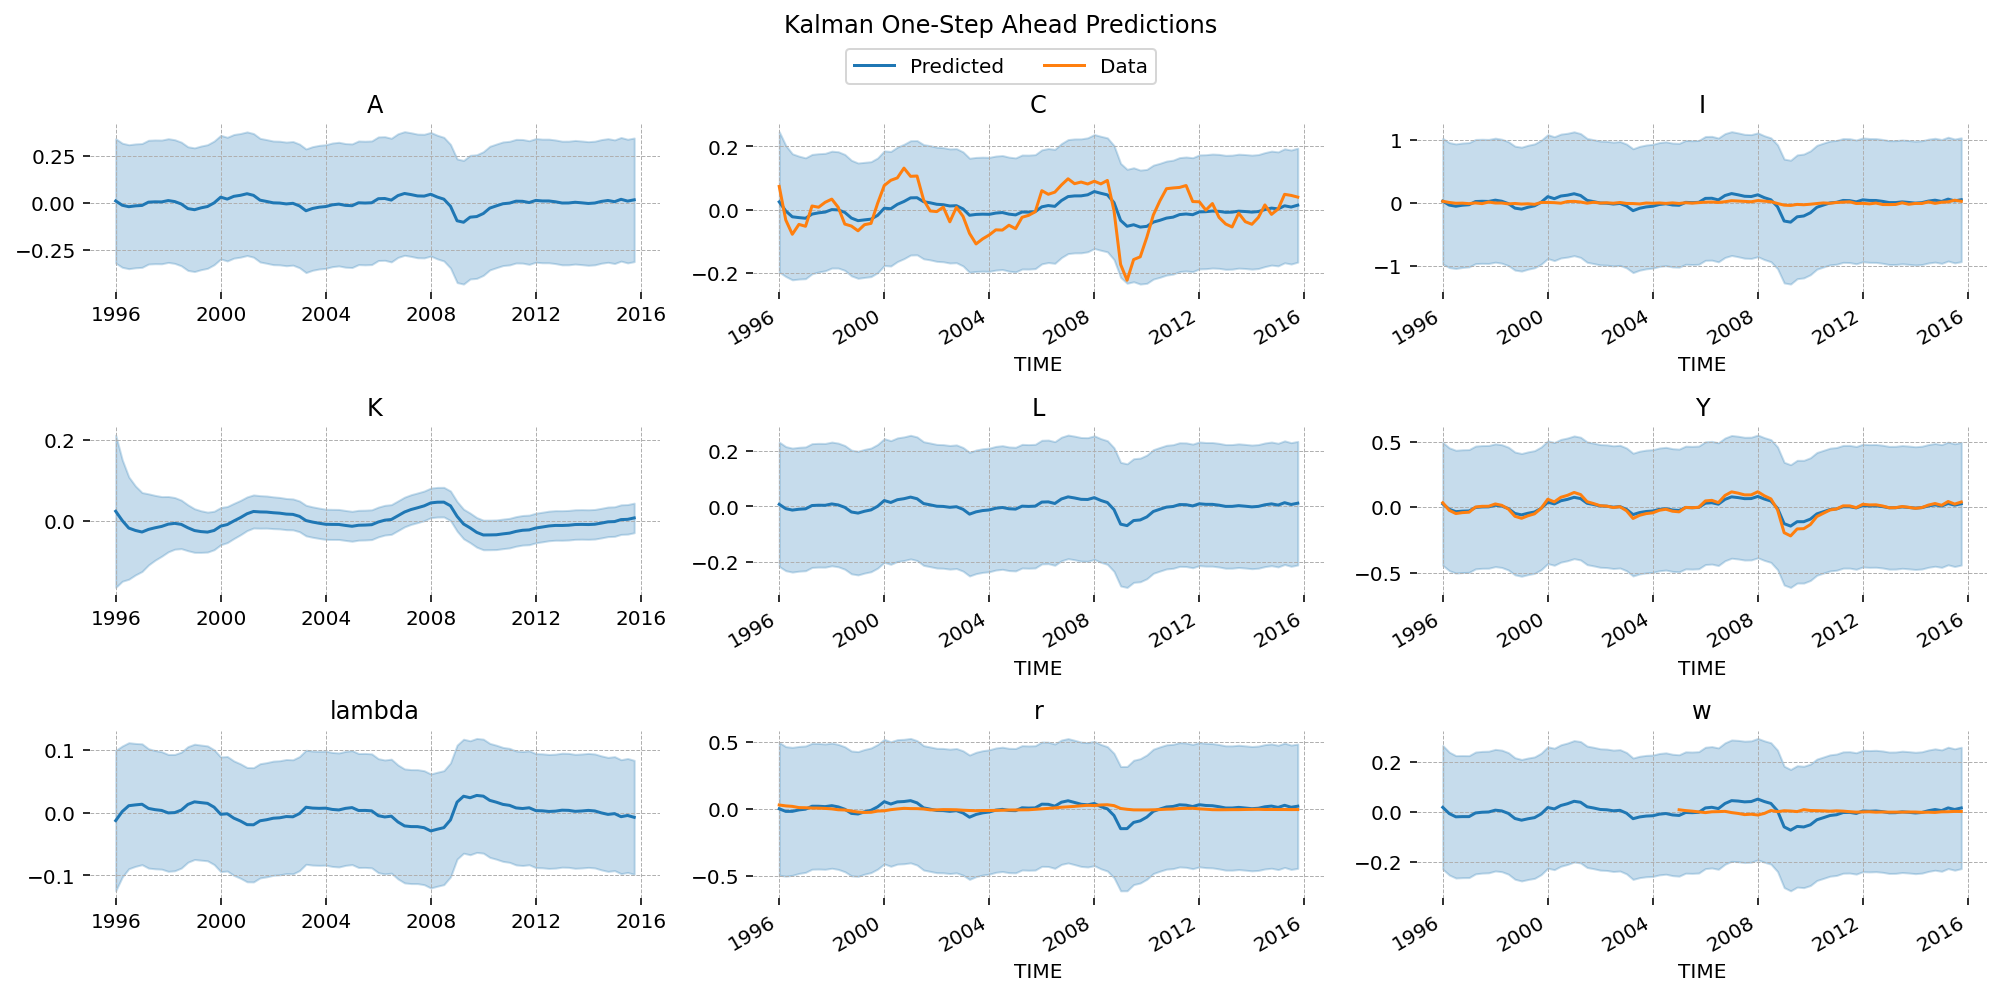

In [26]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

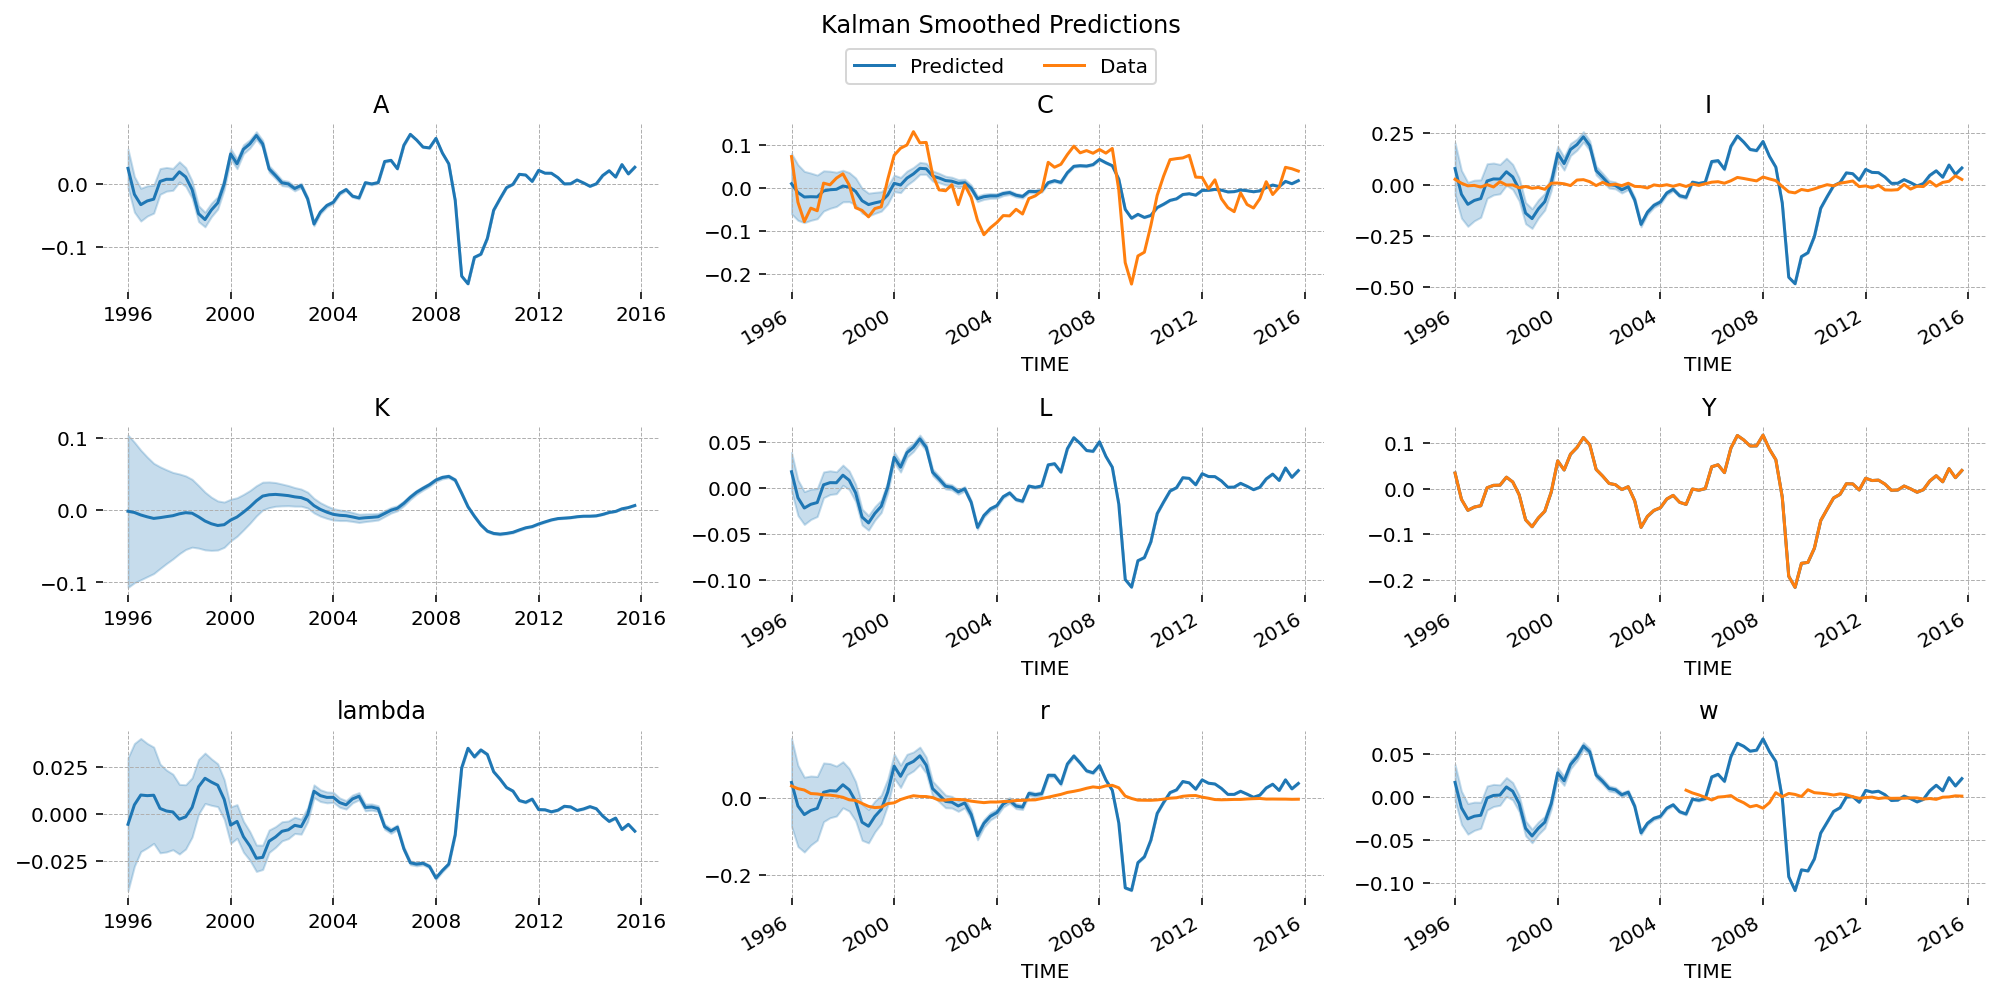

In [27]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [28]:
mle_forecast = mle_res.get_forecast(steps=test_size)

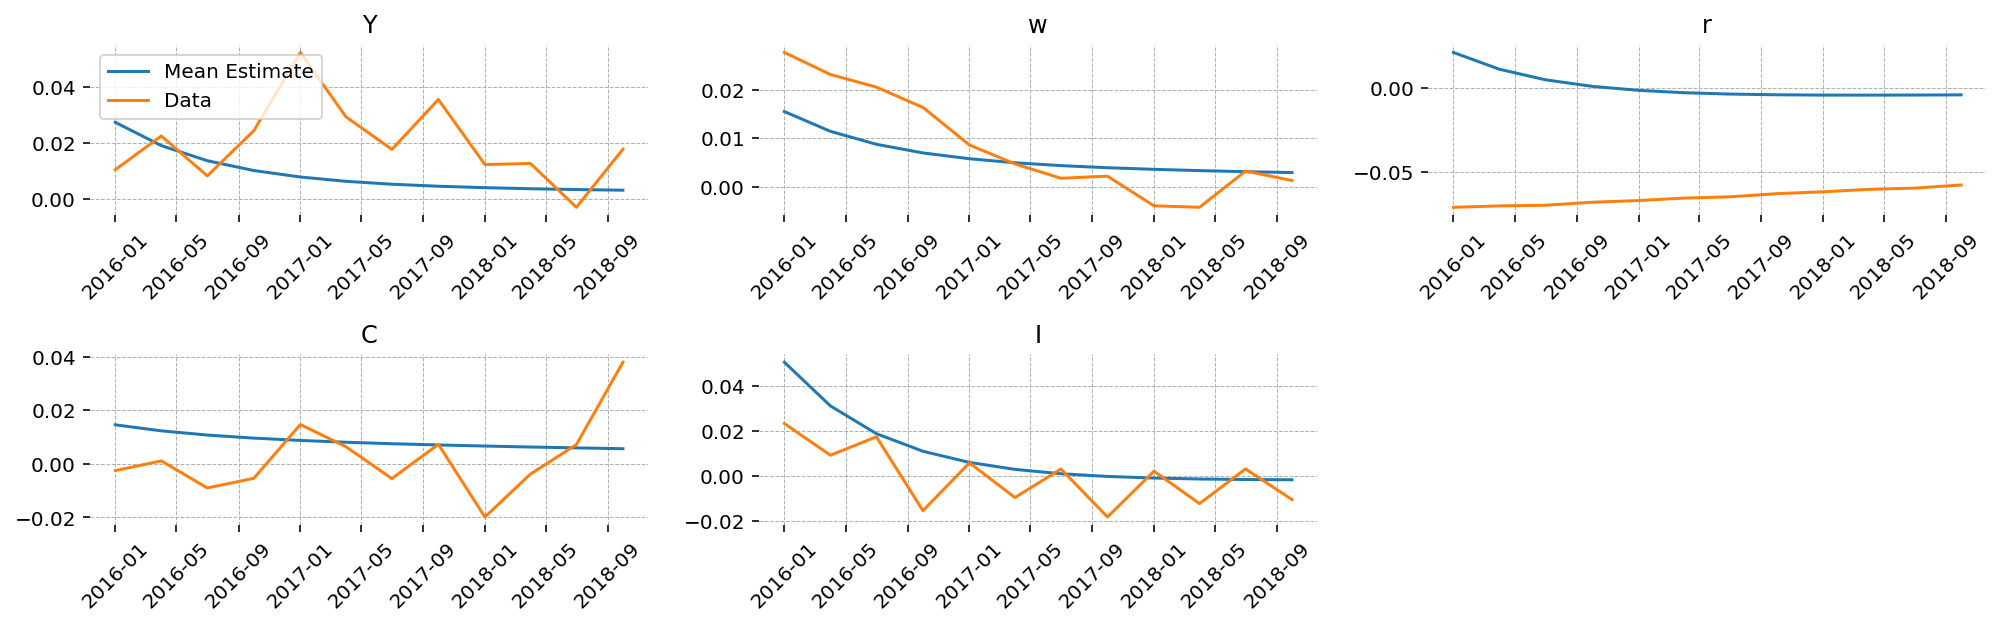

In [29]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

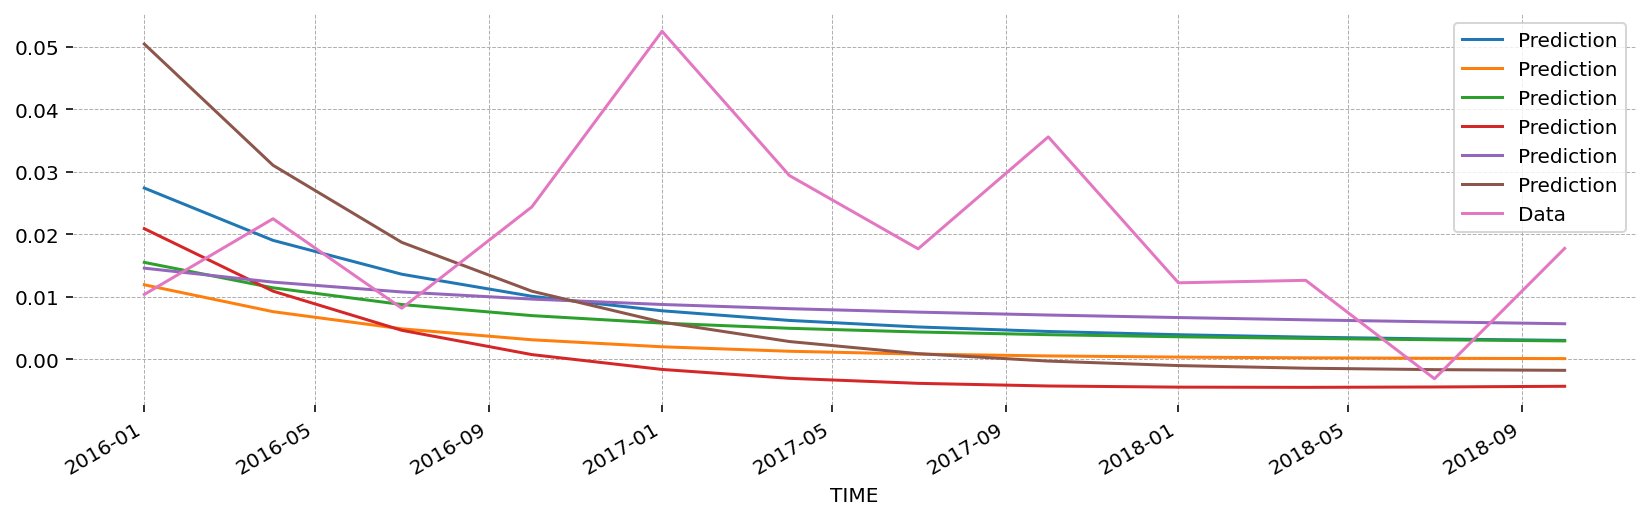

In [30]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Impulse response <a class="anchor" id="section_4_5"></a>

In [31]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

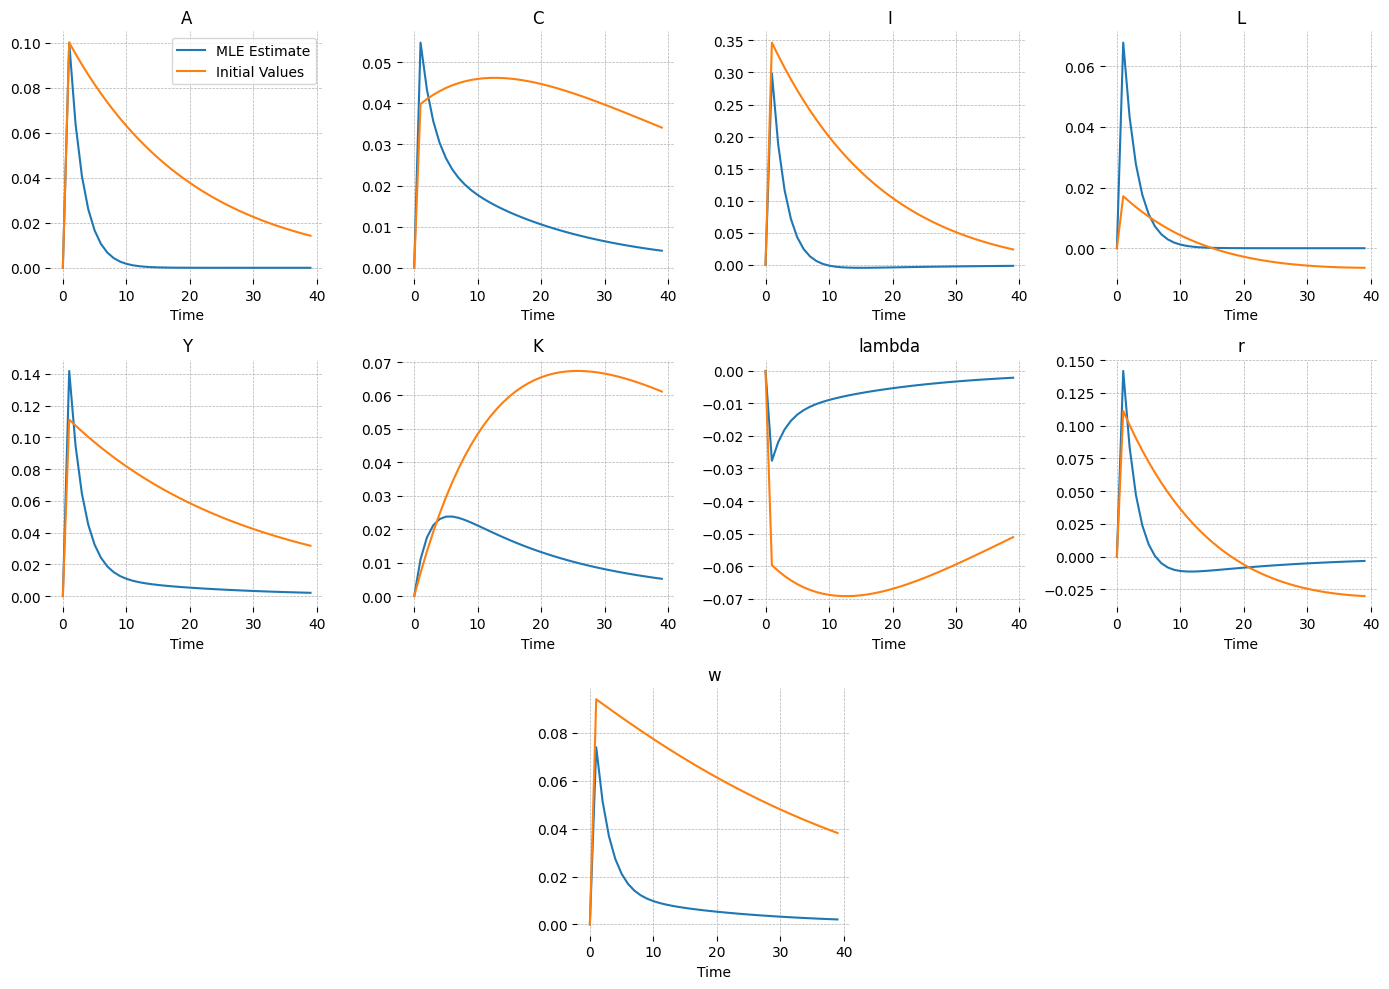

<Figure size 1400x1000 with 0 Axes>

In [32]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

# Bond Model

In [76]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_bonds.gnc'))

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_3_1"></a>

In [77]:
for equation in rbc.system_equations:
    display(equation)

-C_t + Div_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

beta*lambda_t+1 - lambda_t/r_G_t

-Div_t + TC_t + Y_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_3_2"></a>

In [79]:
rbc.steady_state()
rbc.solve_model(not_loglin_variable=['Div', 'TC'])

Steady state found! Sum of squared residuals is 1.830403819145629e-30
Solution found, sum of squared residuals:  1.1745423963278836e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [80]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
Div_ss             0.000
I_ss               0.715
K_ss              35.732
L_ss               0.820
TC_ss             -3.073
Y_ss               3.073
lambda_ss          0.276
r_G_ss             1.010
r_ss               0.030
w_ss               2.436


## Check Blanchard Kahn Conditions <a class="anchor" id="section_3_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [81]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,2.504247e-36,2.504247e-36,0.0
1,4.579401e-34,-4.579401e-34,-0.0
2,6.167997e-19,6.167997e-19,0.0
3,8.149949e-19,8.149949e-19,0.0
4,3.366465e-18,3.366465e-18,0.0
5,9.434787e-17,9.434787e-17,0.0
6,9.500000e-01,9.500000e-01,0.0
7,9.697454e-01,9.697454e-01,0.0
8,1.041615e+00,1.041615e+00,0.0
9,5.077961e+06,5.077961e+06,0.0


In [82]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [83]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,-0.038572,-0.008759,0.097885,0.022497,NaN,0.022162
1996-04-01,-0.041820,-0.003640,0.091451,-0.007947,NaN,0.017030
1996-07-01,-0.045196,-0.000573,0.085275,-0.029443,NaN,0.012016
1996-10-01,-0.044496,0.001199,0.079549,-0.034302,NaN,0.007327
1997-01-01,-0.037604,-0.001199,0.074687,-0.027251,NaN,0.003230


## Final model <a class="anchor" id="section_4_4"></a>

In [84]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [85]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':0.1,
                    'sigma_L':0.3,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=0.001, high=5.0),
                    'sigma_L':IntervalTransformer(low=0.001, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [86]:
%%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=1)

In [87]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                                  DSGEModel   Log Likelihood                 -68.935
Date:                            Fri, 09 Dec 2022   AIC                            161.870
Time:                                    22:49:03   BIC                            190.454
Sample:                                01-01-1996   HQIC                           173.330
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.3678     31.741      0.012      0.991     -61.844      62.580
sigma_C              0.0193      2.337      0.008      0.993      -4.561       4.600
sigma_L              0.0960     18.991      0.005      0.996     -37.125      37.317
alpha                0.4529    107.750      0.004      0.997    -210.733     211.639
beta                 0.9972      6.667      0.150      0.881     -12.070      14.064
delta                0.0390      5.585      0.007      0.994     -10.907      10.985
sigma2.epsilon_A     0.0165      6.406      0.003      0.998     -12.540      12.573
sigma2.L             0.0640      2.450      0.026      0.979      -4.738       4.866
sigma2.w             0.2071      0.127      1.628      0.104      -0.042       0.456
sigma2.r             2.0488    306.332      0.007      0.995    -598.350     602.448
sigma2.C             0.1727      9.159      0.019      0.985     -17.779      18.125
sigma2.I             0.2625     43.831      0.006      0.995     -85.645      86.170
============================================================================================================================
Ljung-Box (L1) (Q):     72.13, 74.25, 74.08, 70.46, 73.39, 73.25   Jarque-Bera (JB):   14.08, 2.62, 4.45, 11.72, 6.01, 27.32
Prob(Q):                      0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):              0.00, 0.27, 0.11, 0.00, 0.05, 0.00
Heteroskedasticity (H):        1.52, 1.10, inf, 0.02, 2.09, 2.03   Skew:                -0.76, 0.39, 0.55, 0.88, -0.59, 1.09
Prob(H) (two-sided):          0.28, 0.80, 0.00, 0.00, 0.06, 0.07   Kurtosis:              4.38, 3.43, 3.35, 3.63, 3.65, 4.85
============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="section_4_7"></a>

Predictions

The model does not pick-up on much variation in the data. Confidence intervals are rather broad and predicted variations seem random. In magnitude deviations go far beyond the actual data, suggesting that the model has not capture the variance correctly.

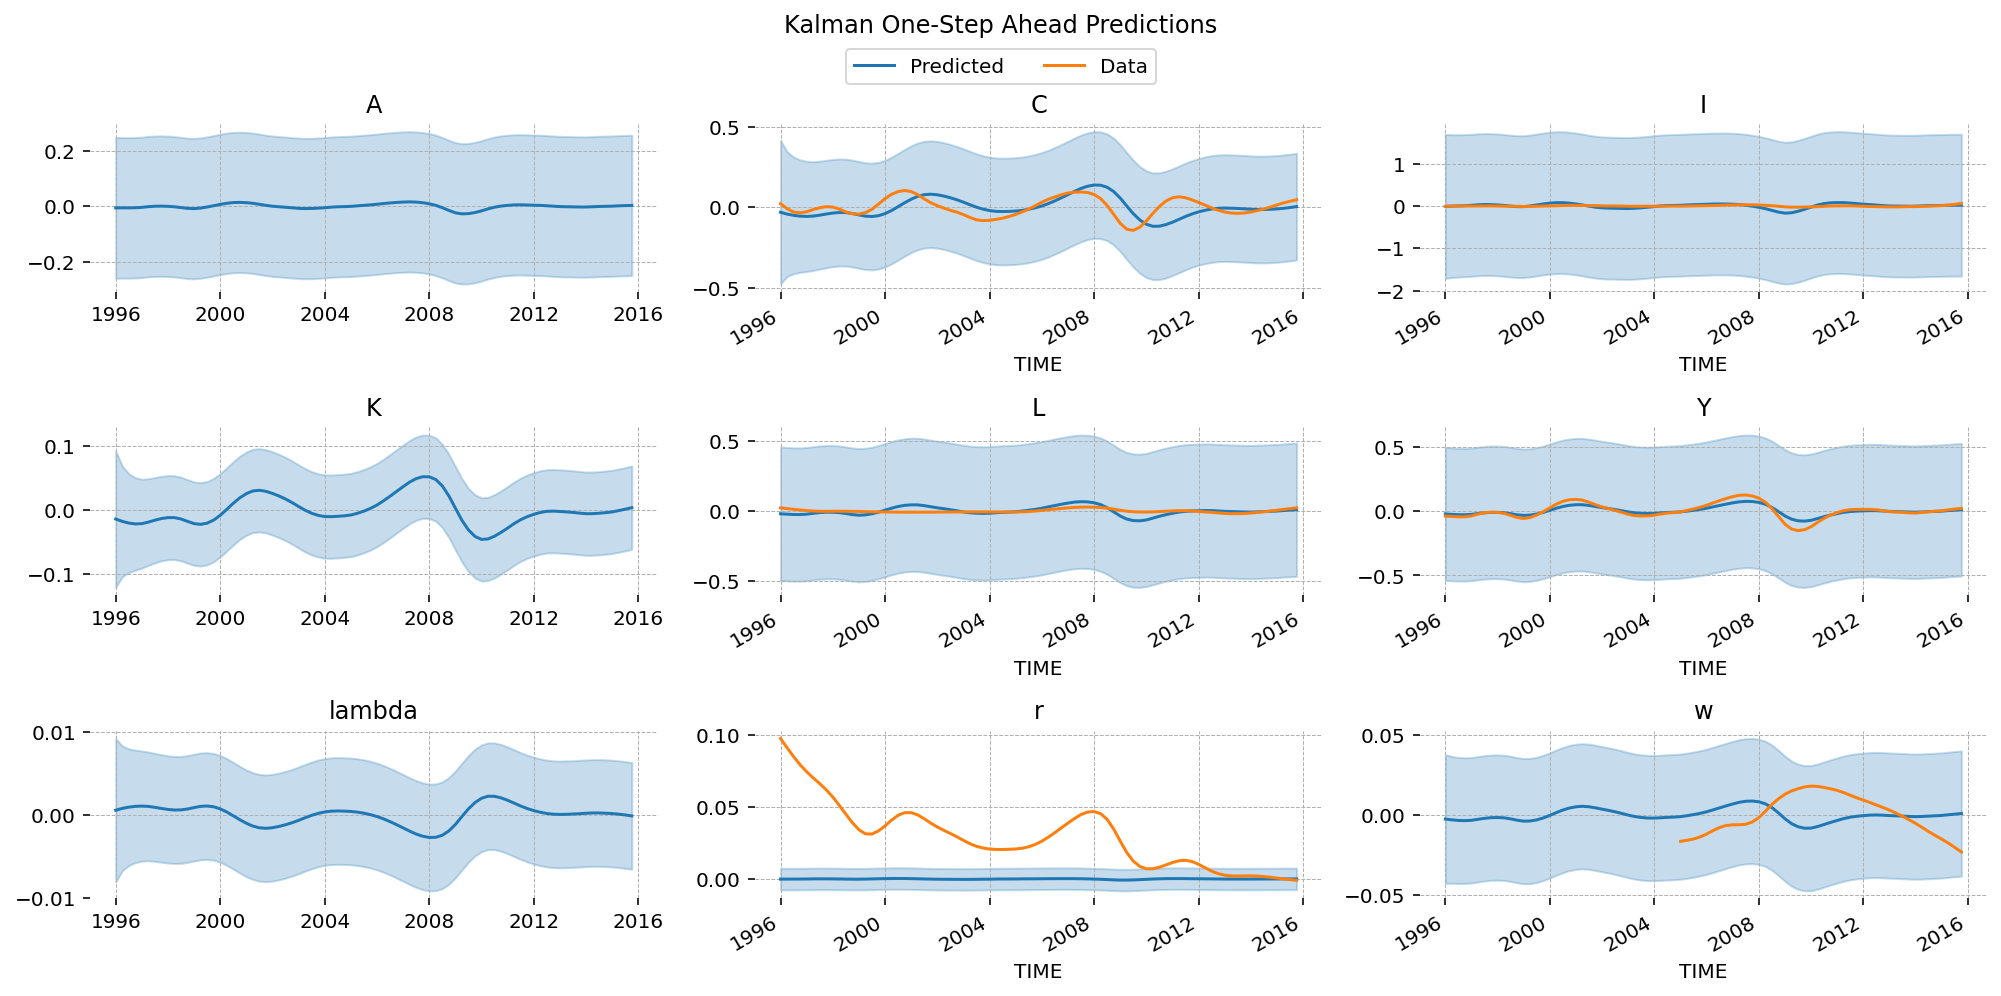

In [88]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

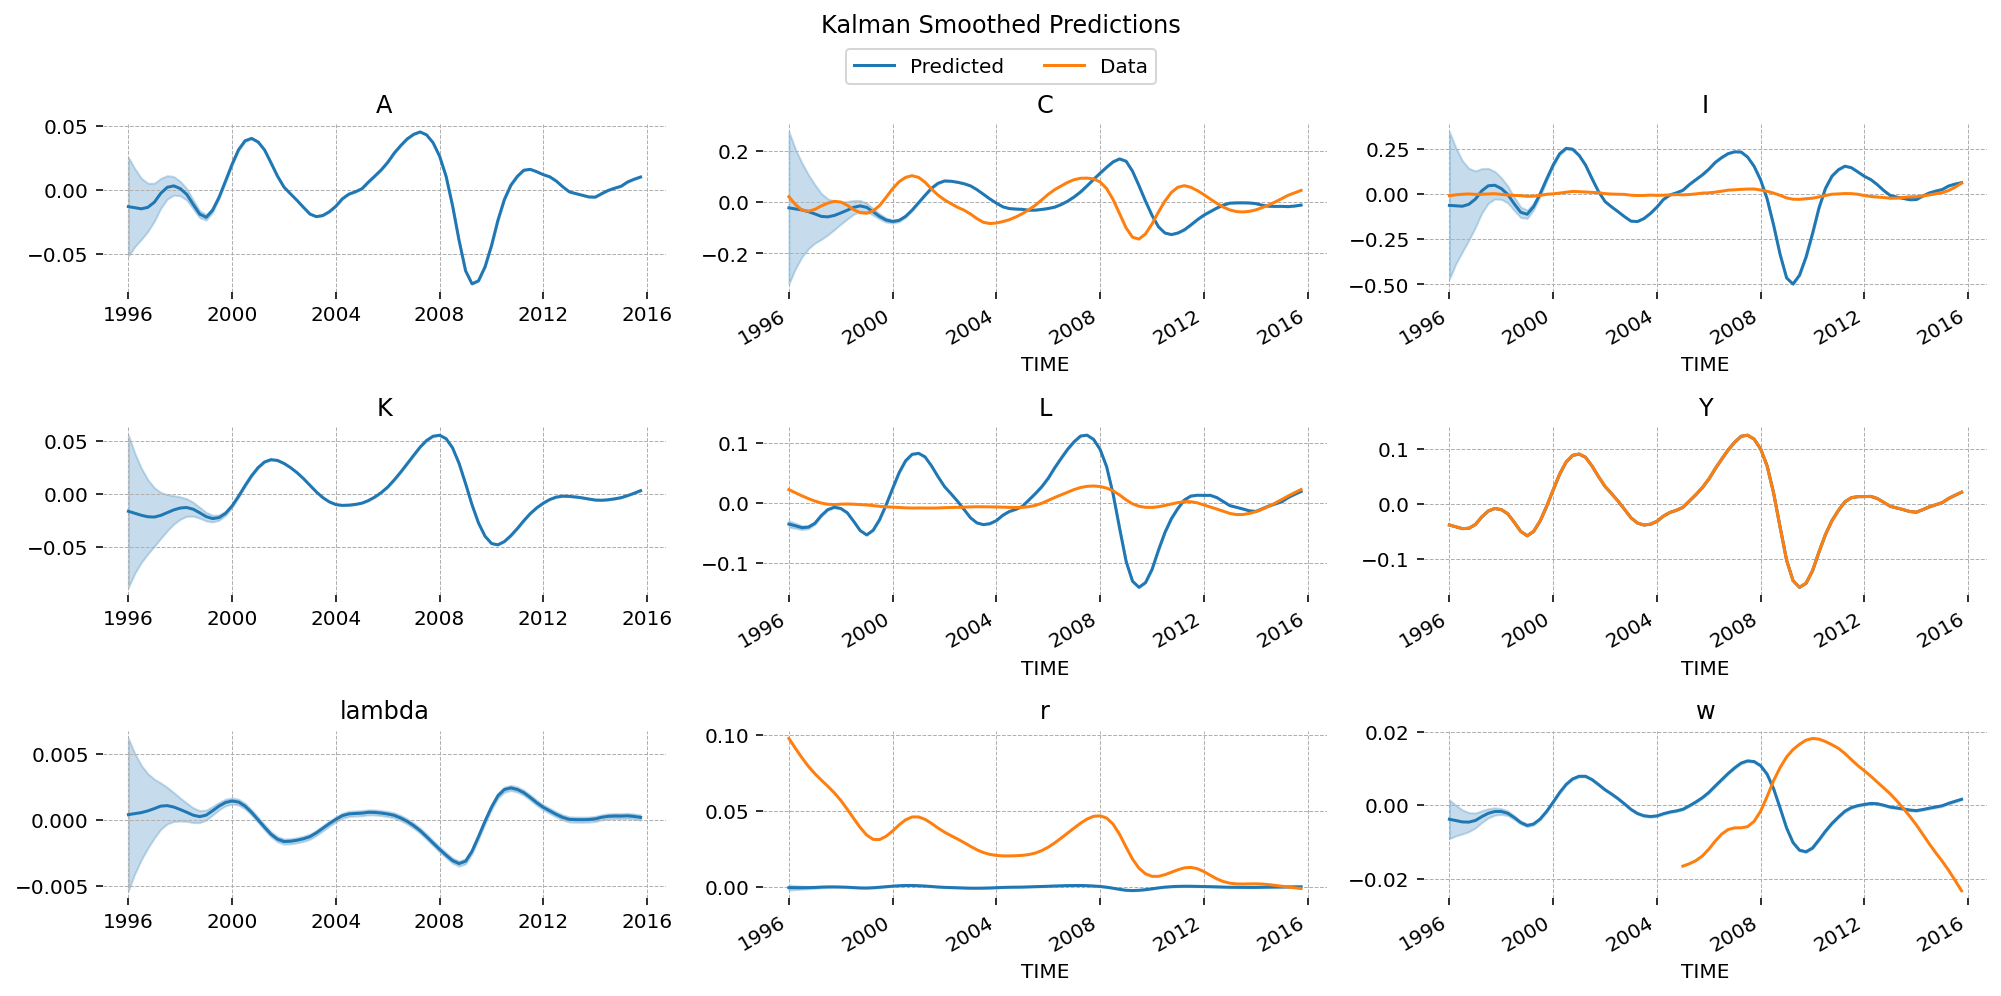

In [89]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="section_4_8"></a>

In [90]:
mle_forecast = mle_res.get_forecast(steps=test_size)

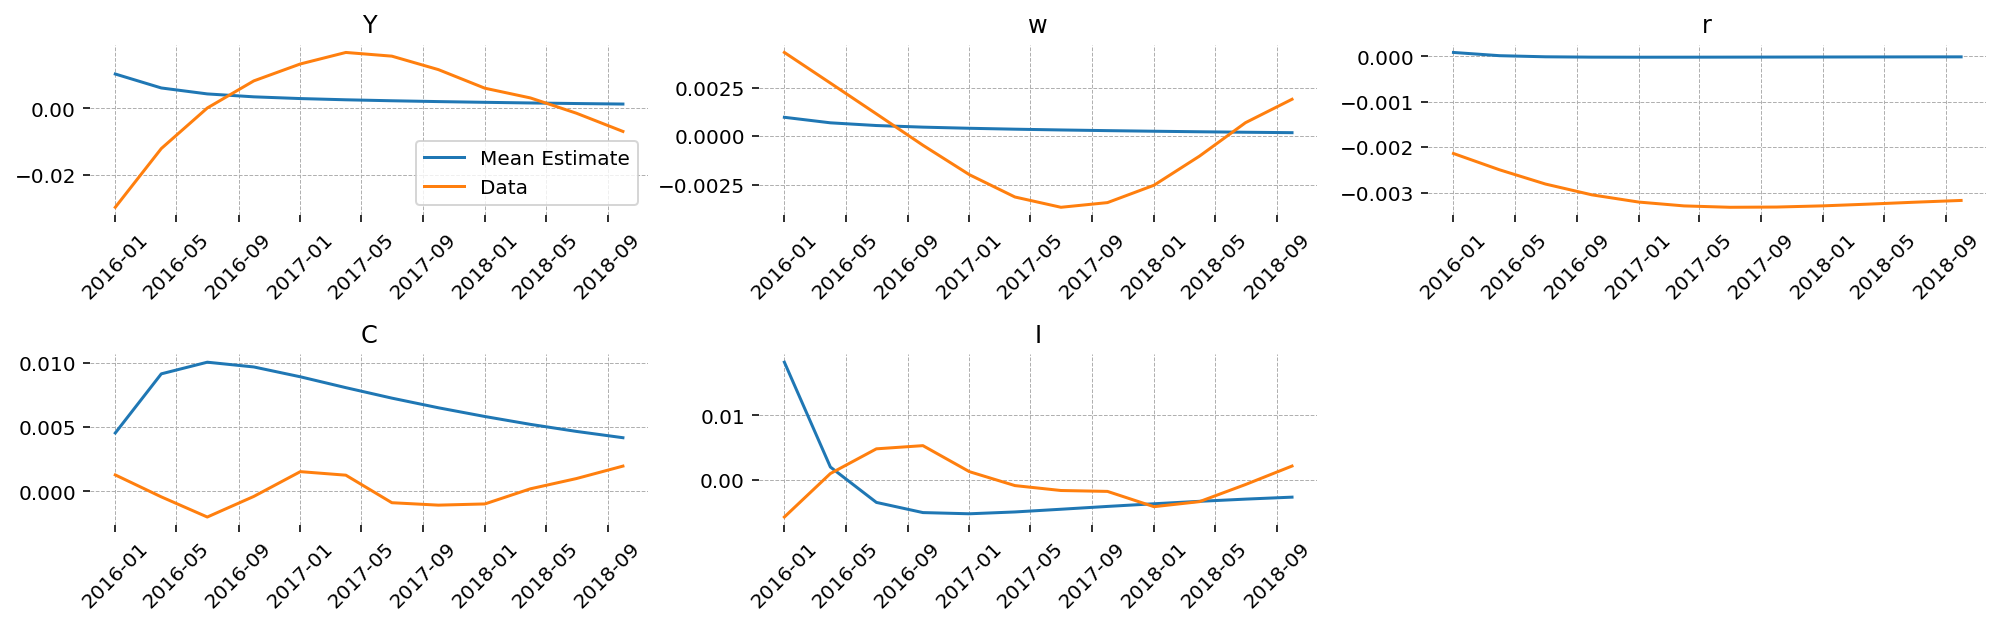

In [91]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

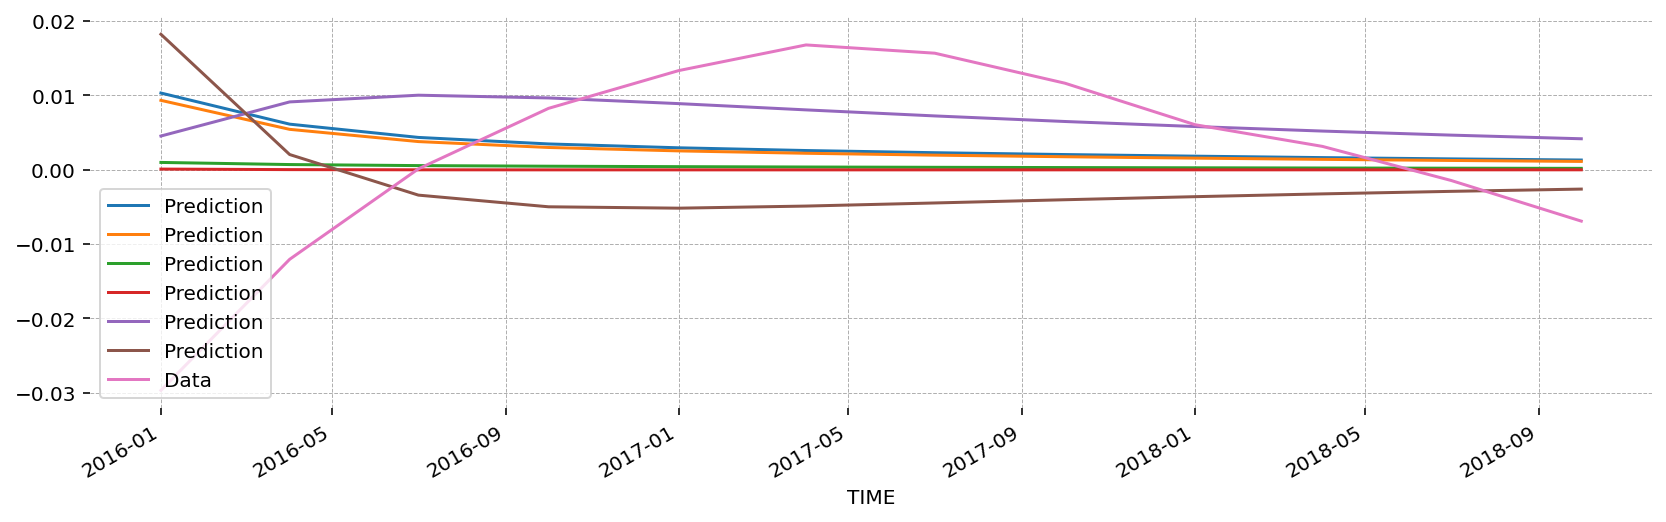

In [92]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Impulse response <a class="anchor" id="section_4_5"></a>

In [93]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

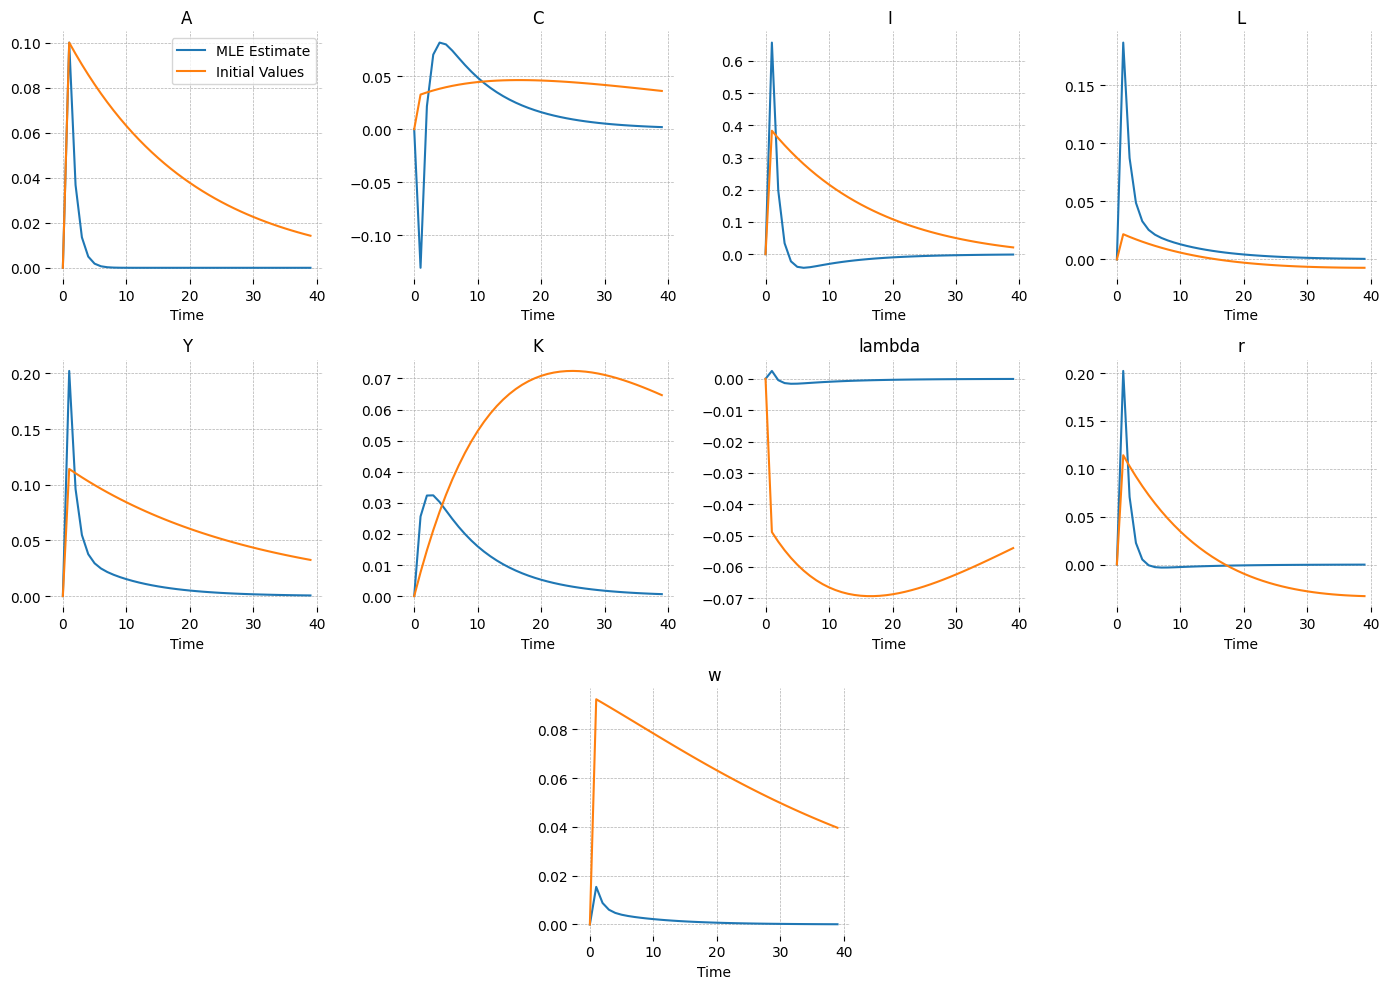

<Figure size 1400x1000 with 0 Axes>

In [94]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()